In [386]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

from train import FaceMaskDataset, get_transform

#### Data Exploration



In [387]:
def show_images(images, titles=None):
    """This function shows images in a single figure with matplotlib.
    
    Parameters:
    ----------
    images: list of np.array
        The images to be displayed.
    titles: list of str
        The titles of each image.
    """
    if titles is None:
        titles = ['Image (%d)' % i for i in range(len(images))]
    fig = plt.figure(figsize=(16, 16))
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

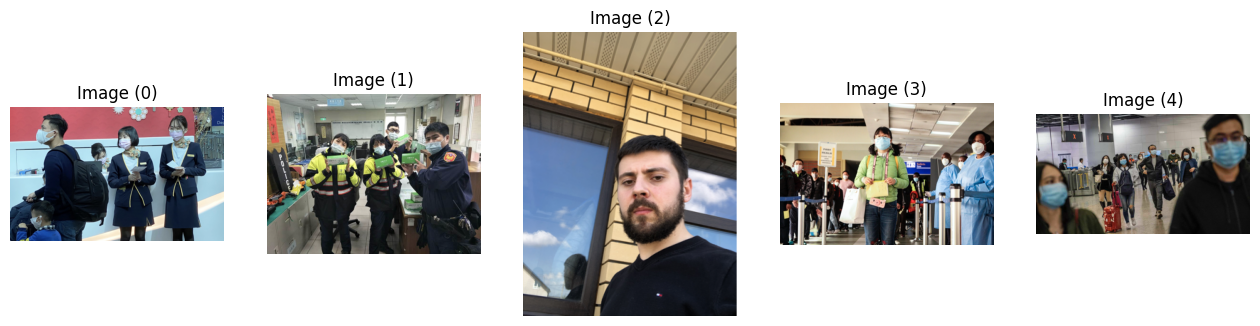

In [388]:
# This cell take random images from dataset and plot them using show_images function
images_path = os.listdir("images")
images = []
for image_path in random.sample(images_path, k=5):
    image_path = os.path.join("images", image_path)
    images.append(Image.open(image_path))
show_images(images)

### Most populated image

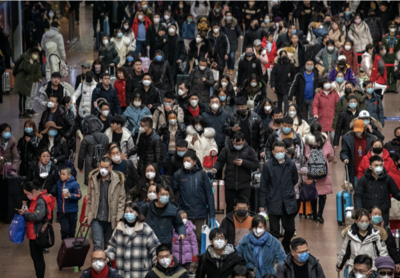

In [389]:
Image.open("images/maksssksksss603.png")

In [390]:
print("Quantity of Images ", len(images_path))

Quantity of Images  853


In [391]:
annotations_path = os.listdir("annotations")

In [392]:
# This cell shows de distribution of classes in the dataset
labels = {}
for path in annotations_path:
    tree = ET.parse("annotations/" + path)
    for child in tree.findall("object"):
        labels[child.find("name").text] = labels.get(child.find("name").text, 0) + 1
print(labels)
print("Quantity of Persons", sum(labels.values()))


{'without_mask': 717, 'with_mask': 3232, 'mask_weared_incorrect': 123}
Quantity of Persons 4072


In [393]:
#This cell shows the distribution of persons per image in the dataset
person_per_image = {}
for path in annotations_path:
    tree = ET.parse("annotations/" + path)
    person_per_image[len(tree.findall("object"))] = person_per_image.get(len(tree.findall("object")), 0) + 1

In [394]:
person_per_image[1]

329

In [395]:
import matplotlib
%matplotlib inline

Text(0.5, 0, 'Quantity of Persons')

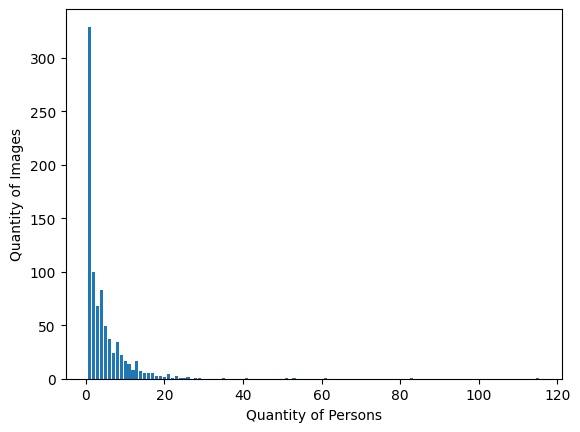

In [396]:
plt.bar(person_per_image.keys(), person_per_image.values(), align='center')
plt.ylabel("Quantity of Images")
plt.xlabel("Quantity of Persons")

### Model Testing

In [397]:
import torch
import utils

In [398]:
model = torch.load("models/fasterrcnn_model_mobilenet_v3.pth")

In [399]:
#Load the dataset using de Dataloader class
dataset_len = 853
dataset_test = FaceMaskDataset('.', get_transform(train=False))

indices = torch.randperm(dataset_len).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

img, target = dataset_test[0]

In [400]:
model.eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
from time import time
start = time()
with torch.no_grad():
    for data, target in dataset_test:
            prediction = model([data.to(device)])
end = time()
print("Dataset size", len(dataset_test))
print("Time: ", end - start)
print("Inferece time per Image: ", (end - start)/len(dataset_test))



Dataset size 200
Time:  9.91838002204895
Inferece time per Image:  0.04959190011024475


In [401]:
prediction = model([img.to(device)])

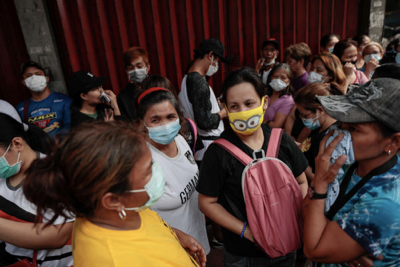

In [402]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [410]:
import cv2
names = {1:"mask", 2:"no_mask", 3:"mask_incorrect"}

def draw_bounding_box(image, boxes):
    """Draw bounding boxes on image using OpenCV"""
    image = image.cpu().permute(1, 2, 0).numpy().copy()
    for box, confidence, label in zip(boxes["boxes"], boxes["scores"], boxes["labels"]):
        if confidence > 0.5:
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            result = cv2.putText(image, f"{names[label.item()]} {round(100*confidence.item())} %", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            result = cv2.rectangle(image, (x, y), (w, h), (0, 0, 255),2)
    # cv2.imshow("bounding_box", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return result

In [418]:
result = draw_bounding_box(img, prediction[0])

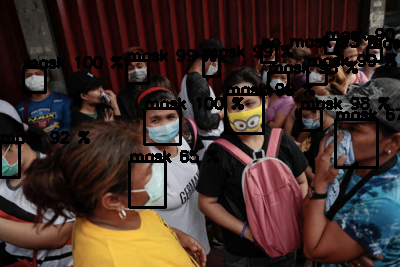

In [431]:
Image.fromarray((result * 255).astype(np.uint8))